## Inference Code

In [17]:
print(tf.__version__)

2.15.0


##### Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
import random
import math
import re
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils

# Root directory of the project
#ROOT_DIR = "D:\MRCNN_tensorflow2.7_env\Mask-RCNN"
ROOT_DIR = os.getcwd()
ROOT_DIR = os.path.normpath(ROOT_DIR)
print("Working Dir: ", ROOT_DIR)
DATASET_DIR = os.path.join(ROOT_DIR, 'Datasets/logoDetector/')
DATASET_DIR = os.path.normpath(DATASET_DIR)
print("Dataset Dir: ", DATASET_DIR)

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library


# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "LogoDetectorModel/preTrainedModel/mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "LogoDetectorModel/trainingLogs/sewez20240618T0707/trainingLogs")


Working Dir:  /content
Dataset Dir:  /content/Datasets/logoDetector


##### Load configs and model

In [12]:
class TrainingConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "sewez"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # Background + sewez_tshirt, sewez_tshirt_logo, sewez_tshirt_brand

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 5

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

    # Training Learning Rate
    LEARNING_RATE = 0.001
class InferenceConfig(TrainingConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    #Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.7

    # Non-maximum suppression threshold for detection
    DETECTION_NMS_THRESHOLD = 0.3

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=DEFAULT_LOGS_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")


#model_path = model.find_last()
model_path = os.path.join(ROOT_DIR, 'LogoDetectorModel/trainingLogs/mask_rcnn_sewez_0300.h5')


# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)
model.load_weights(model_path, by_name=True,exclude=[
                    "mrcnn_class_logits", "mrcnn_bbox_fc",
                    "mrcnn_bbox", "mrcnn_mask"])



Loading weights from  /content/LogoDetectorModel/trainingLogs/mask_rcnn_sewez_0300.h5


In [13]:
class TrainingDataset(utils.Dataset):

    def load_training_dataset(self, dataset_dir, subset):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("sewez", 1, "sewez_tshirt")
        self.add_class("sewez", 2, "sewez_tshirt_logo")
        self.add_class("sewez", 3, "sewez_tshirt_brand")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        annotations = json.load(open(os.path.join(dataset_dir, "annotation.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 

            # iterate names
            objects = [s['region_attributes']['names'] for s in a['regions']]
            name_dict = {"sewez_tshirt": 1, "sewez_tshirt_logo": 2, "sewez_tshirt_brand": 3}
            num_ids = [name_dict[a] for a in objects]

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "sewez",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a Dog-Cat dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "sewez":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "sewez":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [14]:
# Training dataset.
dataset_train = TrainingDataset()
dataset_train.load_training_dataset(DATASET_DIR, "train")
dataset_train.prepare()

# Validation dataset
dataset_val = TrainingDataset()
dataset_val.load_training_dataset(DATASET_DIR, "val")
dataset_val.prepare()

##### Run Inference

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max: 1269.00000  float64
gt_class_id              shape: (6,)                  min:    1.00000  max:    3.00000  int32
gt_bbox                  shape: (6, 4)                min:   14.00000  max: 1017.00000  int32
gt_mask                  shape: (1024, 1024, 6)       min:    0.00000  max:    1.00000  uint8
[[ 233   14  793  509]
 [ 272  228  289  274]
 [ 347  319  408  380]
 [ 655  366  755  390]
 [ 232  522  791 1017]
 [ 339  675  458  881]]


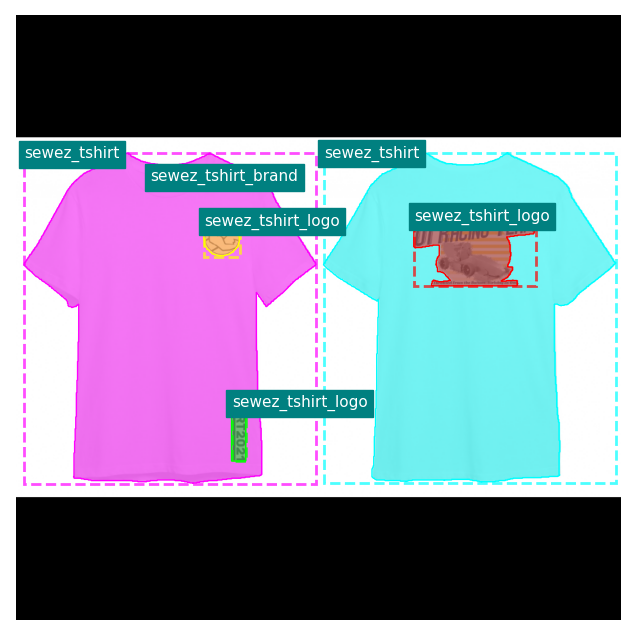

In [15]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
print(gt_bbox)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

#### Running Code

Processing 1 images
image                    shape: (1080, 1080, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -119.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1080.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


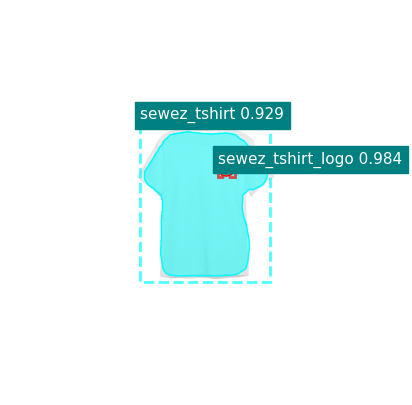

0.15010570824524314
[{'tshirt': {'id': 1, 'score': 0.9292083, 'dimension': {'x': 371, 'y': 473, 'area': 175483, 'maskArea': 106211}, 'roi': [294, 362, 767, 733], 'dimensionCM': {'x': 55.6892177589852, 'y': 71, 'area': 3953.934460887949, 'maskArea': 2393.1169003571285}}, 'logos': [{'id': 2, 'score': 0.98389584, 'dimension': {'x': 48, 'y': 46, 'area': 2208, 'maskArea': 1728}, 'roi': [420, 585, 466, 633], 'dimensionCM': {'x': 7.20507399577167, 'y': 6.904862579281184, 'area': 49.750045814355765, 'maskArea': 38.93481846340886}}]}]
Terdeteksi 1  Tshirt dan  1  Logo
Processing 1 images
image                    shape: (1080, 1080, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1080.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


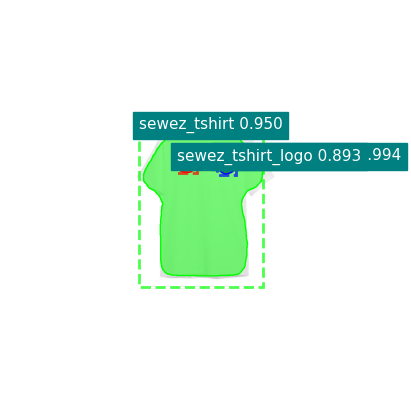

0.15502183406113537
[{'tshirt': {'id': 1, 'score': 0.94955224, 'dimension': {'x': 355, 'y': 458, 'area': 162590, 'maskArea': 105350}, 'roi': [322, 358, 780, 713], 'dimensionCM': {'x': 55.032751091703055, 'y': 71, 'area': 3907.325327510917, 'maskArea': 2531.7468679086974}}, 'logos': [{'id': 2, 'score': 0.9936047, 'dimension': {'x': 54, 'y': 50, 'area': 2700, 'maskArea': 2044}, 'roi': [411, 582, 461, 636], 'dimensionCM': {'x': 8.37117903930131, 'y': 7.751091703056769, 'area': 64.88577639633112, 'maskArea': 49.12093590892622}}, {'id': 2, 'score': 0.8933331, 'dimension': {'x': 58, 'y': 43, 'area': 2494, 'maskArea': 1852}, 'roi': [412, 467, 455, 525], 'dimensionCM': {'x': 8.991266375545852, 'y': 6.665938864628821, 'area': 59.935231974981406, 'maskArea': 44.506836254076006}}]}]
Terdeteksi 1  Tshirt dan  2  Logo
Processing 1 images
image                    shape: (489, 447, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000

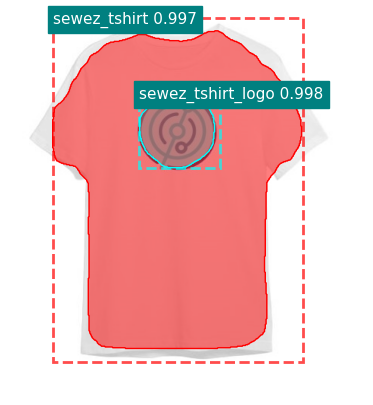

0.15604395604395604
[{'tshirt': {'id': 1, 'score': 0.9969108, 'dimension': {'x': 331, 'y': 455, 'area': 150605, 'maskArea': 103974}, 'roi': [0, 47, 455, 378], 'dimensionCM': {'x': 51.65054945054945, 'y': 71, 'area': 3667.189010989011, 'maskArea': 2531.737394034537}}, 'logos': [{'id': 2, 'score': 0.99827915, 'dimension': {'x': 106, 'y': 100, 'area': 10600, 'maskArea': 7745}, 'roi': [99, 161, 199, 267], 'dimensionCM': {'x': 16.540659340659342, 'y': 15.604395604395604, 'area': 258.10699190918973, 'maskArea': 188.58855210723343}}]}]
Terdeteksi 1  Tshirt dan  1  Logo
Processing 1 images
image                    shape: (1080, 1080, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1080.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


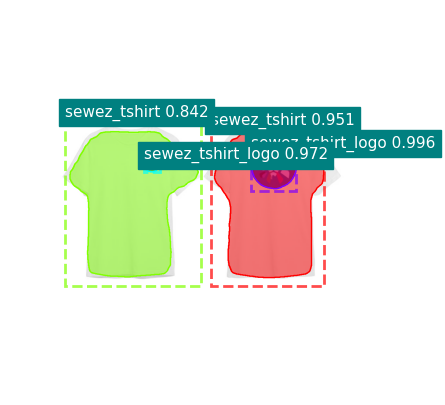

0.1513859275053305
0.1440162271805274
[{'tshirt': {'id': 1, 'score': 0.9513955, 'dimension': {'x': 324, 'y': 469, 'area': 151956, 'maskArea': 102820}, 'roi': [309, 563, 778, 887], 'dimensionCM': {'x': 49.049040511727085, 'y': 71, 'area': 3482.481876332623, 'maskArea': 2356.3978159764692}}, 'logos': [{'id': 2, 'score': 0.9958526, 'dimension': {'x': 130, 'y': 133, 'area': 17290, 'maskArea': 12352}, 'roi': [375, 678, 508, 808], 'dimensionCM': {'x': 19.680170575692966, 'y': 20.134328358208958, 'area': 396.2470165165644, 'maskArea': 283.07941862421075}}]}, {'tshirt': {'id': 1, 'score': 0.8419556, 'dimension': {'x': 389, 'y': 493, 'area': 191777, 'maskArea': 104617}, 'roi': [286, 146, 779, 535], 'dimensionCM': {'x': 56.022312373225155, 'y': 71, 'area': 3977.584178498986, 'maskArea': 2169.827059564121}}, 'logos': [{'id': 2, 'score': 0.9715499, 'dimension': {'x': 47, 'y': 46, 'area': 2162, 'maskArea': 1719}, 'roi': [408, 372, 454, 419], 'dimensionCM': {'x': 6.768762677484788, 'y': 6.6247464503

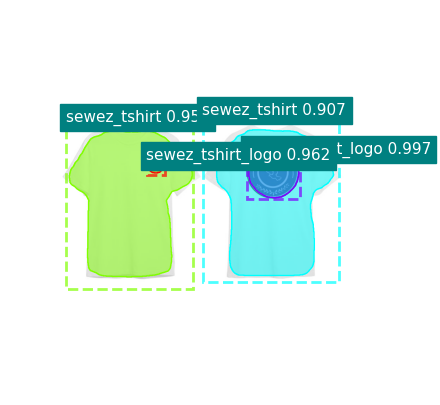

0.14549180327868852
0.14609053497942387
[{'tshirt': {'id': 1, 'score': 0.95603067, 'dimension': {'x': 364, 'y': 488, 'area': 177632, 'maskArea': 105057}, 'roi': [300, 149, 788, 513], 'dimensionCM': {'x': 52.959016393442624, 'y': 71, 'area': 3760.0901639344265, 'maskArea': 2223.832374529696}}, 'logos': [{'id': 2, 'score': 0.9621655, 'dimension': {'x': 52, 'y': 51, 'area': 2652, 'maskArea': 1766}, 'roi': [410, 380, 461, 432], 'dimensionCM': {'x': 7.565573770491803, 'y': 7.420081967213115, 'area': 56.13717750604676, 'maskArea': 37.382449274388605}}]}, {'tshirt': {'id': 1, 'score': 0.90700966, 'dimension': {'x': 391, 'y': 486, 'area': 190026, 'maskArea': 103758}, 'roi': [280, 540, 766, 931], 'dimensionCM': {'x': 57.12139917695473, 'y': 71, 'area': 4055.619341563786, 'maskArea': 2214.4493471523647}}, 'logos': [{'id': 2, 'score': 0.9968771, 'dimension': {'x': 152, 'y': 138, 'area': 20976, 'maskArea': 15319}, 'roi': [392, 666, 530, 818], 'dimensionCM': {'x': 22.20576131687243, 'y': 20.1604938

In [16]:

import skimage

def intersect(boxA, boxB):
    # Compute intersection rectangle coordinates
    xA = max(boxA[1], boxB[1])
    yA = max(boxA[0], boxB[0])
    xB = min(boxA[3], boxB[3])
    yB = min(boxA[2], boxB[2])
    
    # Compute intersection area
    interWidth = max(0, xB - xA)
    interHeight = max(0, yB - yA)
    interArea = interWidth * interHeight
    
    return interArea > 0

real_test_dir = os.path.join(ROOT_DIR, 'Datasets/logoDetector/test')
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

# image_paths = (image_paths[0],)

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    type(visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5)))
    
    detection_result = []
    detected_tshirts = []
    detected_logos = []
    for rows, class_id in enumerate(r['class_ids']):
        detection_id = r['class_ids'][rows]
        detection_score = r['scores'][rows]
        detection_rois = r['rois'][rows].tolist()
        y1, x1, y2, x2 = r['rois'][rows]
        length = y2 - y1
        width = x2 - x1
        dimension = {
            "x": width,
            "y": length,
            "area": length * width,
            "maskArea": np.sum(r['masks'][:,:,rows])
            }
        detection = {
        "id": detection_id,
        "score": detection_score,
        "dimension": dimension,
        "roi": detection_rois,
        }
        detection_result.append(detection)
        if detection_id == 1:
            detected_tshirts.append(detection)
        elif detection_id == 2:
            detected_logos.append(detection)

    grouped_result = []
    for tShirt in detected_tshirts:
        # convert relative unit to cm
        tShirtHeightCM = 71
        ratioToCM = tShirtHeightCM/tShirt["dimension"]["y"]
        print(ratioToCM)
        tShirtWidthCM = ratioToCM * tShirt["dimension"]["x"]
        tShirtAreaCM = tShirtHeightCM * tShirtWidthCM
        tShirtMaskAreaCM = (ratioToCM**2) * tShirt["dimension"]["maskArea"]
        tShirt['dimensionCM'] = {
            "x": tShirtWidthCM,
            "y": tShirtHeightCM,
            "area": tShirtAreaCM,
            "maskArea": tShirtMaskAreaCM
        }
        # List to keep track of logos intersecting with the tshirt
        associated_logos = []
        for logo in detected_logos:
            if intersect(tShirt["roi"], logo["roi"]):
                # convert relative unit to cm
                logoHieghtCM = ratioToCM * logo["dimension"]["y"]
                logoWidthCM = ratioToCM * logo["dimension"]["x"]
                logoAreaCM = logoHieghtCM * logoWidthCM
                logoMaskAreaCM = (ratioToCM**2) * logo["dimension"]["maskArea"]
                logo["dimensionCM"] = {
                    "x": logoWidthCM,
                    "y": logoHieghtCM,
                    "area": logoAreaCM,
                    "maskArea": logoMaskAreaCM
                }
                associated_logos.append(logo)
        tshirt_with_logos = {
            "tshirt": tShirt,
            "logos": associated_logos
        }
        grouped_result.append(tshirt_with_logos)
    
    print(grouped_result)
    print("Terdeteksi", len(detected_tshirts), " Tshirt dan ", len(detected_logos), " Logo")
    detectionData = {
        "numberOfTshirt": len(detected_tshirts),
        "numberOfLogos": len(detected_logos),
        "data": grouped_result
    }   
